In [1]:
%cd ..

/Users/joaquinpolonuer/Documents/software/tesis/zitnik/rags/graphsearch


In [2]:
import torch
import pandas as pd
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt

from src.utils import iterate_qas, load_graph_and_qas, load_embeddings
from src.llms.simple_calls import extract_entities_from_question


graph_name = "prime"
graph, qas = load_graph_and_qas(graph_name)

doc_embeddings, query_embeddings = load_embeddings(graph_name)

corpus = graph.nodes_df["name"].astype(str).tolist()
tokenized_corpus = [doc.lower().split() for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

Using cached llm response
Q[10] 'Please find the genes and proteins that interact with manganese ion binding and ...': best_answer_rank=5093, best_entity_rank=2, Hits@10(ans)=False, Hits@10(ent)=True, MRR(ans)=0.000


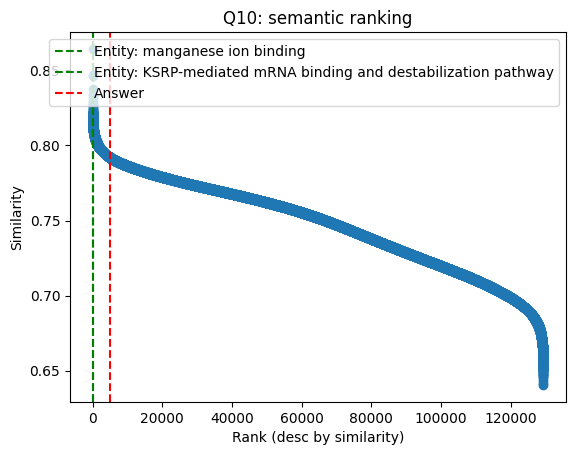

Using cached llm response
Q[11] 'What is the rare condition associated with CD55 that causes enlarged intestinal ...': best_answer_rank=1, best_entity_rank=86, Hits@10(ans)=True, Hits@10(ent)=False, MRR(ans)=1.000


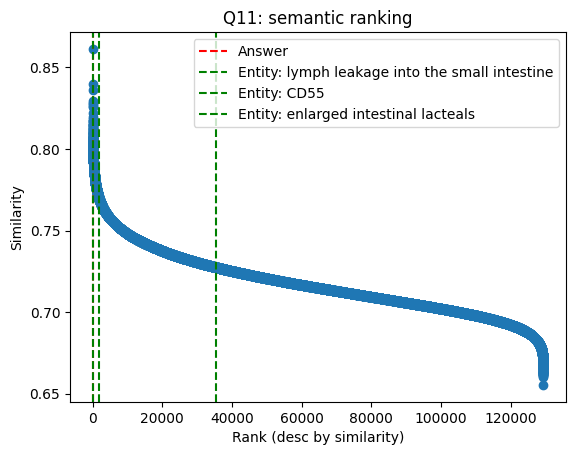

Using cached llm response
Q[12] 'Please find genes or proteins interacting with the High calcium permeable postsy...': best_answer_rank=479, best_entity_rank=1, Hits@10(ans)=False, Hits@10(ent)=True, MRR(ans)=0.002


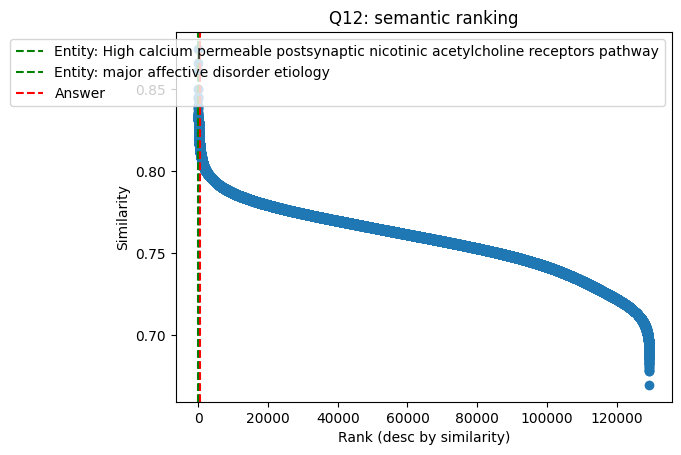

Using cached llm response
Q[13] 'Which genes or proteins interact with the 'mRNA decay by 3' to 5' exoribonucleas...': best_answer_rank=41, best_entity_rank=2, Hits@10(ans)=False, Hits@10(ent)=True, MRR(ans)=0.007


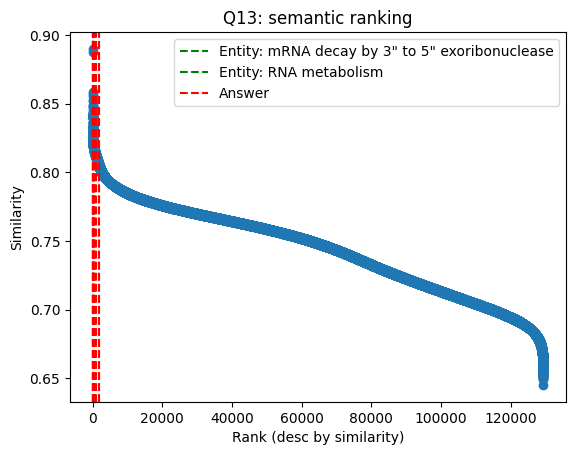

Using cached llm response
Q[14] 'What disease is linked to the HTR1A gene/protein and causes recurring fevers dur...': best_answer_rank=1, best_entity_rank=17, Hits@10(ans)=True, Hits@10(ent)=False, MRR(ans)=1.000


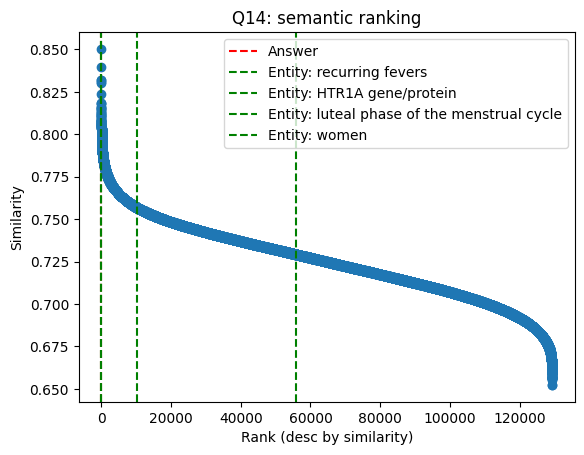

Using cached llm response
Q[15] 'Which pathway is subordinate to 'Metabolic disorders of biological oxidation enz...': best_answer_rank=109, best_entity_rank=1, Hits@10(ans)=False, Hits@10(ent)=True, MRR(ans)=0.009


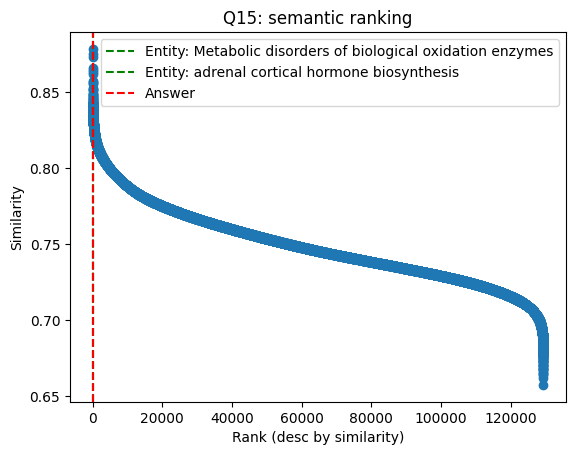

Using cached llm response
Q[16] 'What is the inherited dental disorder characterized by irregularities in both ba...': best_answer_rank=1, best_entity_rank=328, Hits@10(ans)=True, Hits@10(ent)=False, MRR(ans)=1.000


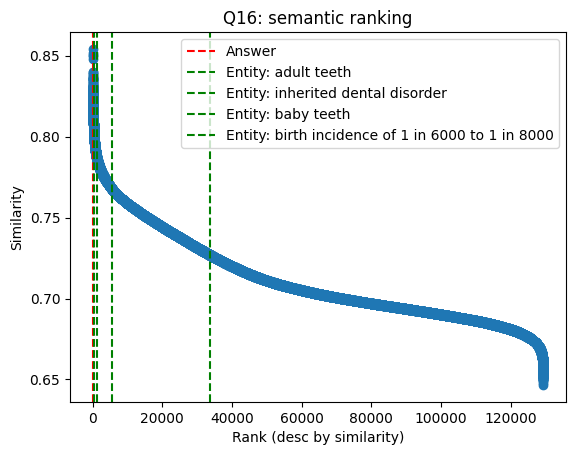

Using cached llm response
Q[17] 'Can you suggest some medications used to treat advanced colorectal cancer that w...': best_answer_rank=3, best_entity_rank=177, Hits@10(ans)=True, Hits@10(ent)=False, MRR(ans)=0.333


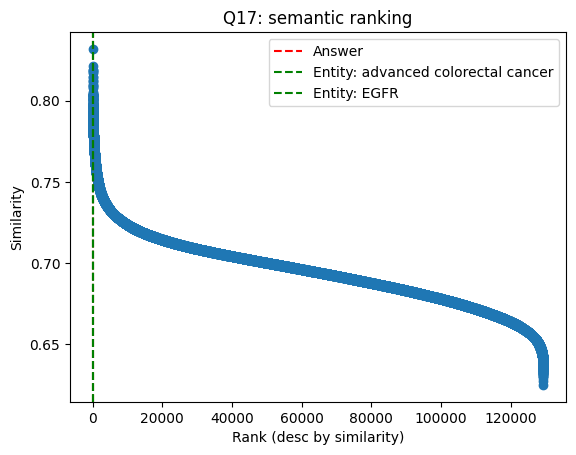

Using cached llm response
Q[18] 'Could you assist in pinpointing a disease akin to 'autosomal recessive axonal he...': best_answer_rank=3, best_entity_rank=2, Hits@10(ans)=True, Hits@10(ent)=True, MRR(ans)=0.084


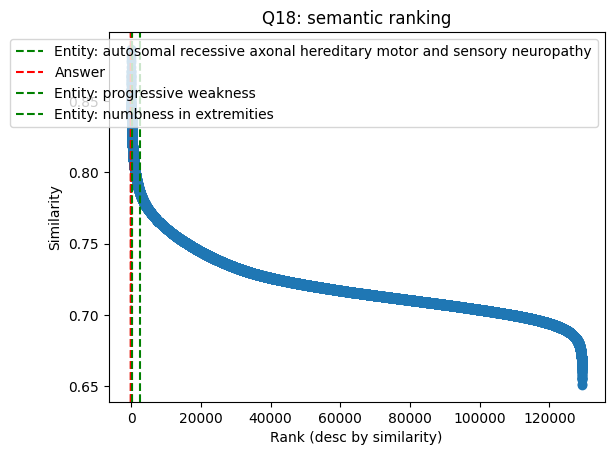

Using cached llm response
Q[19] 'Can you supply a list of oral medications that act on the HDAC8 gene/protein?...': best_answer_rank=15, best_entity_rank=1, Hits@10(ans)=False, Hits@10(ent)=True, MRR(ans)=0.019


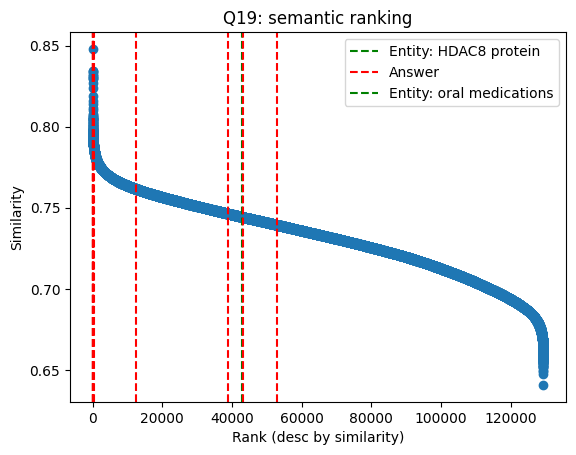

In [6]:
for qidx, question, answer_indices in iterate_qas(qas, limit=1000, shuffle=False)[10:20]:
    entities = extract_entities_from_question(question)

    # --- BM25 top-1 per entity (store both index and original entity string)
    entity_map = {}  # index -> entity name
    for ent in entities:
        tokens = ent.lower().split()
        scores = bm25.get_scores(tokens)
        bm25_df = pd.DataFrame({"bm25_score": scores, "index": graph.nodes_df.index})
        top_idx = bm25_df.sort_values("bm25_score", ascending=False)["index"].iloc[0]
        entity_map[top_idx] = ent
    entity_indices = list(entity_map.keys())

    # --- Build per-question view
    df = graph.nodes_df.copy()
    if "index" not in df.columns:
        df = df.reset_index().rename(columns={"index": "index"})
    idxs = df["index"].tolist()

    # cosine similarity (safer)
    q = query_embeddings[qidx]
    q = q / (q.norm() + 1e-12)
    sims = []
    for x in idxs:
        if x in doc_embeddings:
            v = doc_embeddings[x]
            v = v / (v.norm() + 1e-12)
            sims.append(torch.matmul(q, v.T).item())
        else:
            sims.append(0.0)
    df["similarity"] = sims

    df["is_answer"] = df["index"].isin(answer_indices)
    df["is_entity"] = df["index"].isin(entity_indices)

    sorted_df = df.sort_values("similarity", ascending=False).reset_index(drop=True)

    # --- Numeric diagnostics
    answer_ranks = sorted_df.index[sorted_df["is_answer"]].tolist()
    entity_ranks = sorted_df.index[sorted_df["is_entity"]].tolist()
    best_answer_rank = min(answer_ranks) + 1 if answer_ranks else None
    best_entity_rank = min(entity_ranks) + 1 if entity_ranks else None
    hits_at_10_ans = any(r < 10 for r in answer_ranks)
    hits_at_10_ent = any(r < 10 for r in entity_ranks)
    mrr_ans = sum(1.0 / (r + 1) for r in answer_ranks) / max(len(answer_ranks), 1) if answer_ranks else 0.0

    print(f"Q[{qidx}] '{question[:80]}...': "
          f"best_answer_rank={best_answer_rank}, best_entity_rank={best_entity_rank}, "
          f"Hits@10(ans)={hits_at_10_ans}, Hits@10(ent)={hits_at_10_ent}, MRR(ans)={mrr_ans:.3f}")

    # --- Plot
    plt.figure()
    plt.scatter(range(len(sorted_df)), sorted_df["similarity"])

    added_answer_label = False
    plotted_entities = set()
    for i, row in sorted_df.iterrows():
        if row["is_answer"]:
            plt.axvline(i, color="red", linestyle="--",
                        label="Answer" if not added_answer_label else None)
            added_answer_label = True
        if row["is_entity"] and row["index"] in entity_map:
            ent_label = f"Entity: {entity_map[row['index']]}"
            if row["index"] not in plotted_entities:
                plt.axvline(i, color="green", linestyle="--", label=ent_label)
                plotted_entities.add(row["index"])

    if added_answer_label or plotted_entities:
        plt.legend()
    plt.title(f"Q{qidx}: semantic ranking")
    plt.xlabel("Rank (desc by similarity)")
    plt.ylabel("Similarity")
    plt.show()